In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lingua import Language, LanguageDetectorBuilder
from sacrebleu.metrics import BLEU
from datasets import load_dataset

/home/maksymiakovenko/miniconda3/envs/msc_quant1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
src = "../eval_results/flores/run_1_lang_neurons"
src_ref = "../eval_results/flores/run_1"

In [3]:
langs = [
    ("fr", Language.FRENCH),
    ("es", Language.SPANISH), 
    ("vi", Language.VIETNAMESE), 
    ("id", Language.INDONESIAN),
    ("zh", Language.CHINESE),
    ("ru", Language.RUSSIAN),
    ("uk", Language.UKRAINIAN), 
    ("hi", Language.HINDI),
]

languages = [
    Language.ENGLISH, 
    Language.FRENCH, 
    Language.SPANISH, 
    Language.UKRAINIAN, 
    Language.RUSSIAN, 
    Language.VIETNAMESE, 
    Language.INDONESIAN, 
    Language.CHINESE, 
    Language.HINDI,
]

detector = LanguageDetectorBuilder.from_languages(*languages).build()

def get_filter(l_code, column_name):
    def lang_filter(row):
        return detector.detect_language_of(str(row[column_name])) == l_code
    return lang_filter

quants = [
    (src_ref+"/{lang}/hf_16.csv", "hf 16bit"),
    (src_ref+"/{lang}/rtn_4.csv", "rtn 4bit"),
    (src+"/{lang}/mpq_4_ln.csv", "mpq 4bit ln"),
    (src+"/{lang}/mpq_4_random.csv", "mpq 4bit rng"),
    (src+"/{lang}/mprq_4_ln.csv", "mprq 4bit ln"),
    (src+"/{lang}/mprq_4_random.csv", "mprq 4bit rng"),
    # (src+"/{lang}/twq_4_ln.csv", "twq 4bit\n(lang. neurons)"),
    # (src+"/{lang}/twq_4_random.csv", "twq 4bit\n(random)"),
]

bleu = BLEU(tokenize="flores101")

In [4]:
data_files = {
    "en": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.eng_Latn",
    "fr": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.fra_Latn",
    "ru": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.rus_Cyrl",
    "es": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.spa_Latn",
    "uk": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.ukr_Cyrl",
    "vi": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.vie_Latn",
    "id": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.ind_Latn",
    "hi": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.hin_Deva",
    "zh": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.cmn_Hans",
}

reference_data = load_dataset("text", data_files=data_files)

In [5]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metric = "count"

to_merge = None
for path, name in quants:
    merge = None
    for lang, l_code in langs:
        data = pd.read_csv(path.format(lang=lang), index_col=0)
        # data = data[data.apply(get_filter(l_code), axis=1)]
        data[target_metric] = data.apply(get_filter(l_code, "to"), axis=1).sum()
        data[lang_col_name] = lang
        if merge is None:
            merge = data
        else:
            merge = pd.concat([merge, data])
    merge[quant_col_name] = name
    if to_merge is None:
        to_merge = merge
    else:
        to_merge = pd.concat([to_merge, merge])

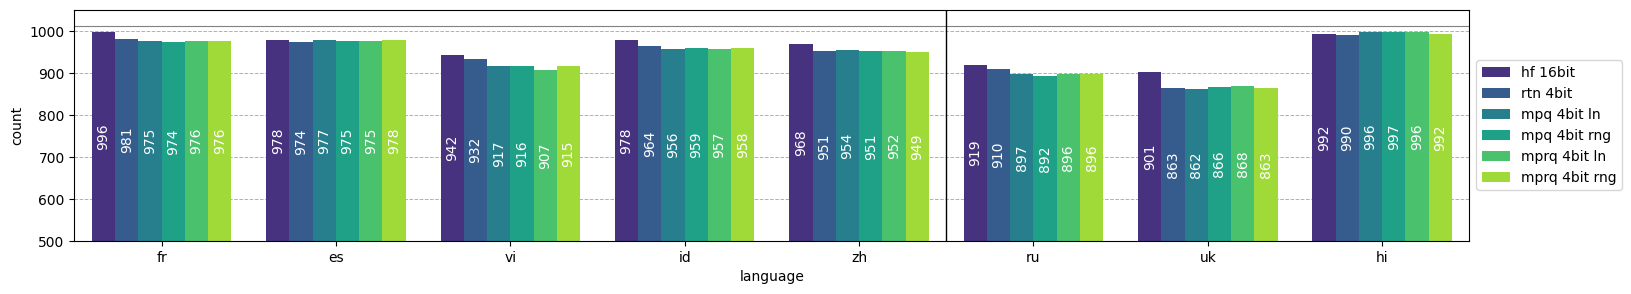

In [6]:
plt.figure(figsize=(18, 3), dpi=100)
plt.ylim(500, 1050)
plt.axhline(y=1012, color='gray', linestyle='-', linewidth=0.8)
plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)
ax = sns.barplot(x=lang_col_name, y=target_metric, hue=quant_col_name, palette="viridis", data=to_merge, saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white")
    for label in labels:
        label.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)

In [7]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metric = "count"

from_merge = None
for path, name in quants:
    merge = None
    for lang, l_code in langs:
        data = pd.read_csv(path.format(lang=lang), index_col=0)
        # data = data[data.apply(get_filter(l_code), axis=1)]
        data[target_metric] = data.apply(get_filter(Language.ENGLISH, "from"), axis=1).sum()
        data[lang_col_name] = lang
        if merge is None:
            merge = data
        else:
            merge = pd.concat([merge, data])
    merge[quant_col_name] = name
    if from_merge is None:
        from_merge = merge
    else:
        from_merge = pd.concat([from_merge, merge])

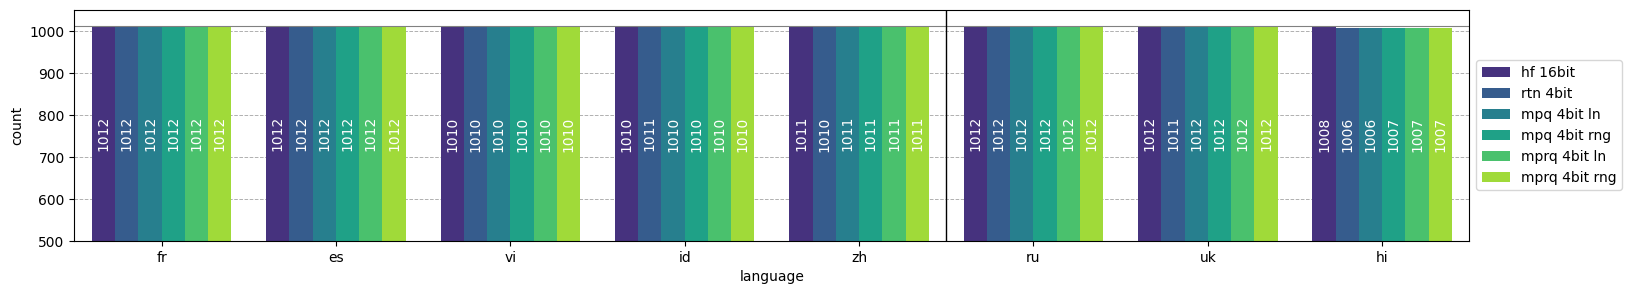

In [8]:
plt.figure(figsize=(18, 3), dpi=100)
plt.ylim(500, 1050)
plt.axhline(y=1012, color='gray', linestyle='-', linewidth=0.8)
plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)
ax = sns.barplot(x=lang_col_name, y=target_metric, hue=quant_col_name, palette="viridis", data=from_merge, saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white")
    for label in labels:
        label.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)

In [9]:
bleu_summary = None
columns = ["quant", "language", "BLEU", "misc", "direction"]

for path, name in quants:
    ref_reverse = reference_data["en"]["text"]
    for lang, l_code in langs:
        data = pd.read_csv(path.format(lang=lang), index_col=0)
        ref = reference_data[lang]["text"]

        bleu_to = bleu.corpus_score(data["to"].to_list(), [[line] for line in ref])
        bleu_from = bleu.corpus_score(data["from"].to_list(), [[line] for line in ref_reverse])

        line = pd.DataFrame([
            [name, lang, bleu_to.score, bleu_to, "to"], 
            [name, lang, bleu_from.score, bleu_from, "from"]
            ], columns=columns)
        
        if bleu_summary is None:
            bleu_summary = line
        else:
            bleu_summary = pd.concat([bleu_summary, line], axis=0, ignore_index=True)

bleu_summary

,quant,language,BLEU,misc,direction
0,hf 16bit,fr,37.160443,BLEU = 37.16 77.4/50.0/27.6/17.9 (BP = 1.000 r...,to
1,hf 16bit,fr,72.256765,BLEU = 72.26 96.3/88.5/64.0/50.0 (BP = 1.000 r...,from
2,hf 16bit,es,35.007877,BLEU = 35.01 76.0/41.7/26.1/18.2 (BP = 1.000 r...,to
3,hf 16bit,es,13.523285,BLEU = 13.52 92.3/40.0/4.2/2.2 (BP = 1.000 rat...,from
4,hf 16bit,vi,25.965359,BLEU = 25.97 100.0/63.6/14.3/5.0 (BP = 1.000 r...,to
...,...,...,...,...,...
91,mprq 4bit rng,ru,23.877931,BLEU = 23.88 90.0/36.8/16.7/5.9 (BP = 1.000 ra...,from
92,mprq 4bit rng,uk,37.481712,BLEU = 37.48 85.0/47.4/27.8/17.6 (BP = 1.000 r...,to
93,mprq 4bit rng,uk,42.728701,BLEU = 42.73 100.0/50.0/33.3/20.0 (BP = 1.000 ...,from
94,mprq 4bit rng,hi,14.113992,BLEU = 14.11 90.5/30.0/5.3/2.8 (BP = 1.000 rat...,to


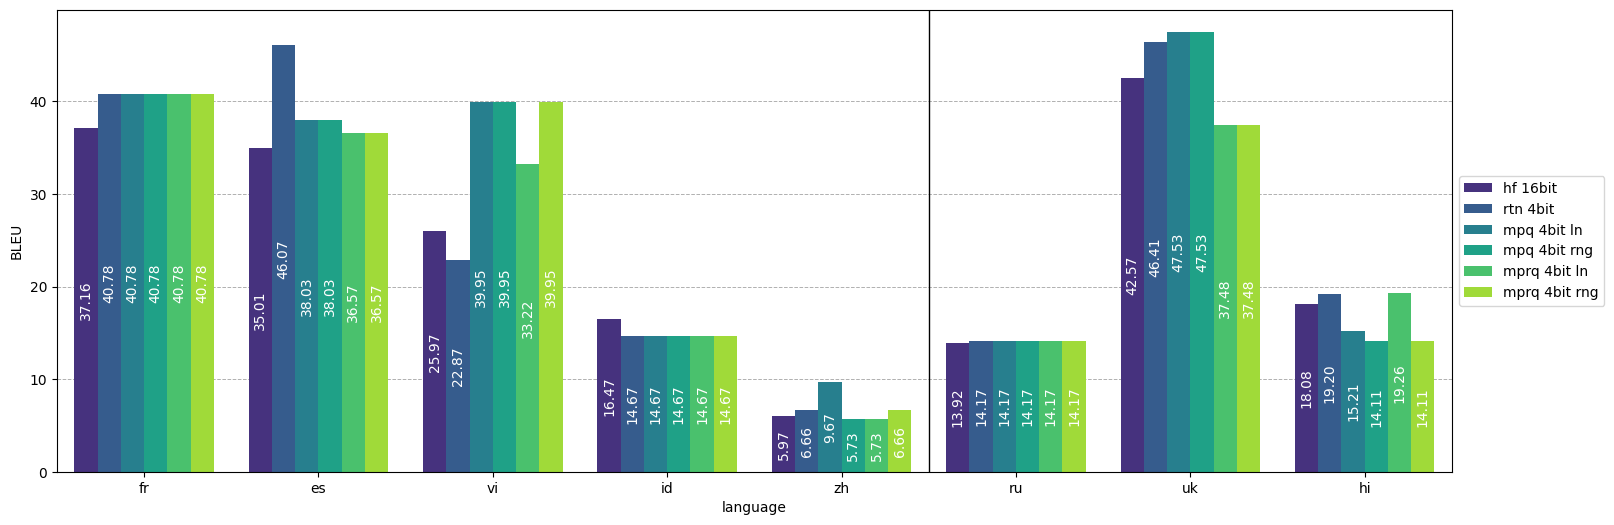

In [10]:
plt.figure(figsize=(18, 6), dpi=100)
plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)
ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary[bleu_summary["direction"]=="to"], saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)

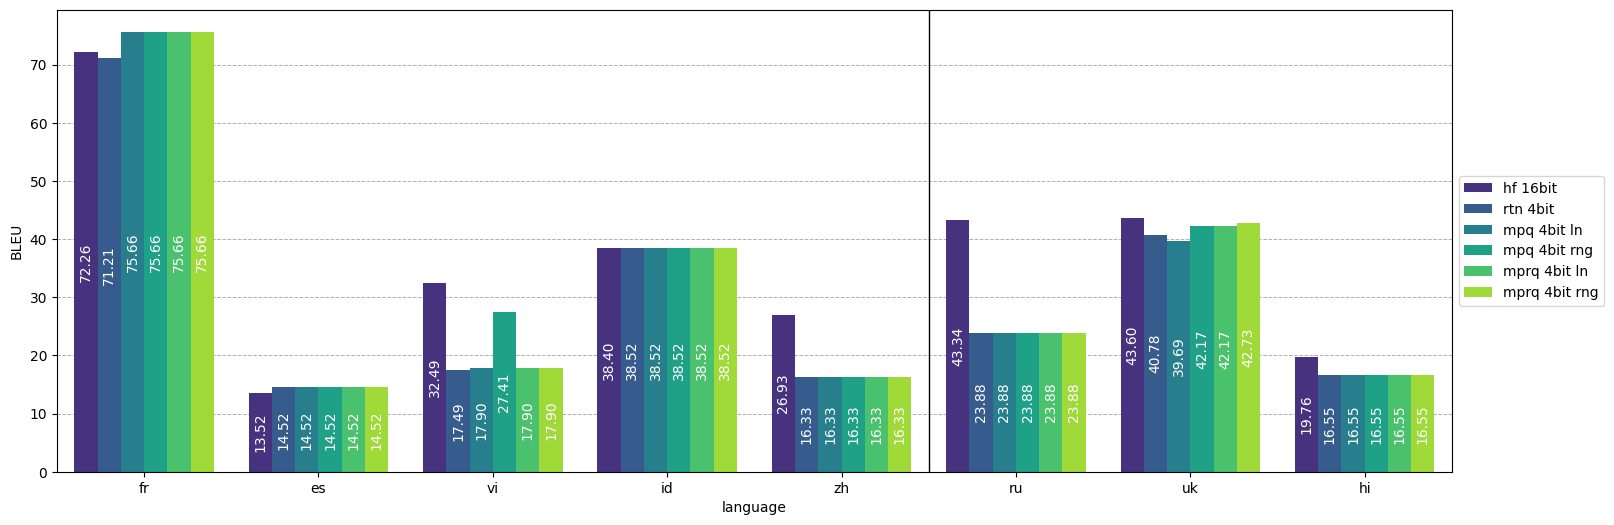

In [11]:
plt.figure(figsize=(18, 6), dpi=100)
plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)
ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary[bleu_summary["direction"]=="from"], saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)

In [12]:
bleu_summary_avg = None
columns = ["quant", "language", "BLEU", "direction"]

for path, name in quants:
    ref_reverse = reference_data["en"]["text"]
    for lang, l_code in langs:
        data = pd.read_csv(path.format(lang=lang), index_col=0)

        ref = reference_data[lang]["text"]

        for n in range(len(ref_reverse)):
            bleu_to = bleu.corpus_score([data["to"].to_list()[n]], [[ref[n]]]).score
            bleu_from = bleu.corpus_score([data["from"].to_list()[n]], [[ref_reverse[n]]]).score

            line = pd.DataFrame([
                [name, lang, bleu_to, "to"], 
                [name, lang, bleu_from, "from"]
                ], columns=columns)
        
            if bleu_summary_avg is None:
                bleu_summary_avg = line
            else:
                bleu_summary_avg = pd.concat([bleu_summary_avg, line], axis=0, ignore_index=True)

bleu_summary_avg

,quant,language,BLEU,direction
0,hf 16bit,fr,26.848384,to
1,hf 16bit,fr,59.009730,from
2,hf 16bit,fr,56.976641,to
3,hf 16bit,fr,58.391361,from
4,hf 16bit,fr,13.011055,to
...,...,...,...,...
97147,mprq 4bit rng,hi,9.018038,from
97148,mprq 4bit rng,hi,2.775639,to
97149,mprq 4bit rng,hi,2.042946,from
97150,mprq 4bit rng,hi,2.197748,to


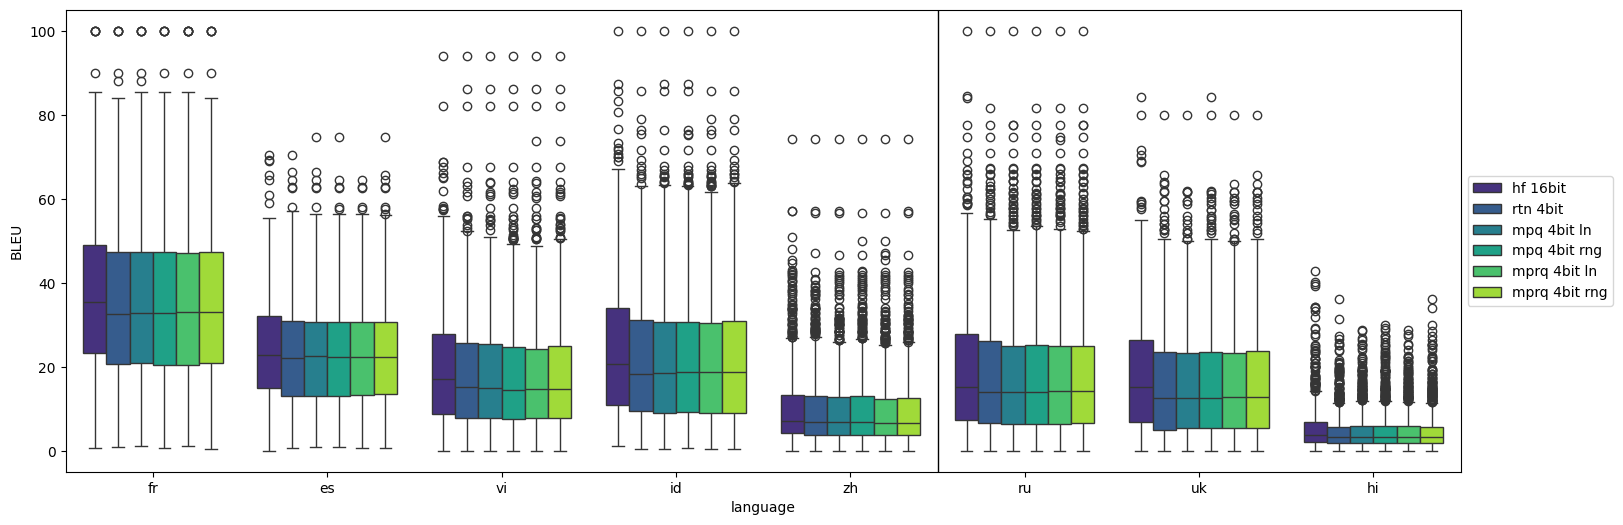

In [13]:
plt.figure(figsize=(18, 6), dpi=100)
plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)
ax = sns.boxplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary_avg[bleu_summary_avg["direction"]=="to"], saturation=1)
# for container in ax.containers:
#     labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
#     for label in labels:
#         label.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

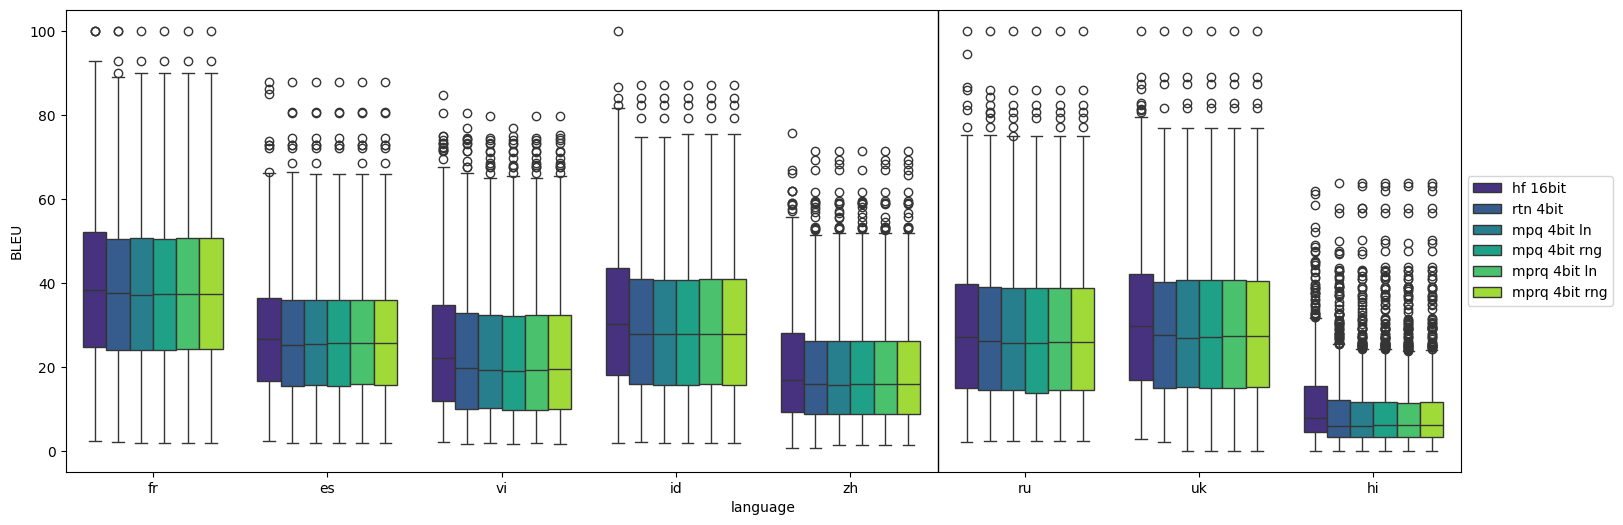

In [14]:
plt.figure(figsize=(18, 6), dpi=100)
plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)
ax = sns.boxplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary_avg[bleu_summary_avg["direction"]=="from"], saturation=1)
# for container in ax.containers:
#     labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
#     for label in labels:
#         label.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 1.0, 'BLEU scores for translating to the target language from English, evaluated on the sentence level')

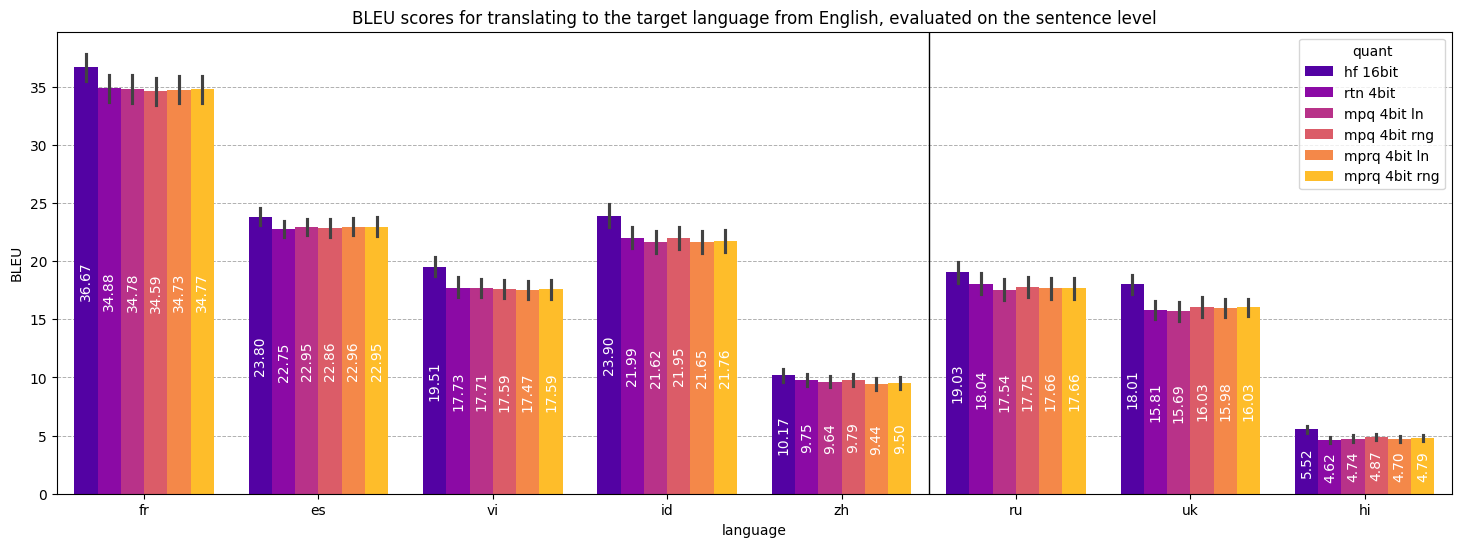

In [15]:
plt.figure(figsize=(18, 6), dpi=100)
plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)
ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="plasma", data=bleu_summary_avg[bleu_summary_avg["direction"]=="to"], saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)
ax.set_title("BLEU scores for translating to the target language from English, evaluated on the sentence level")

Text(0.5, 1.0, 'BLEU scores for translating from the target language to English, evaluated on the sentence level')

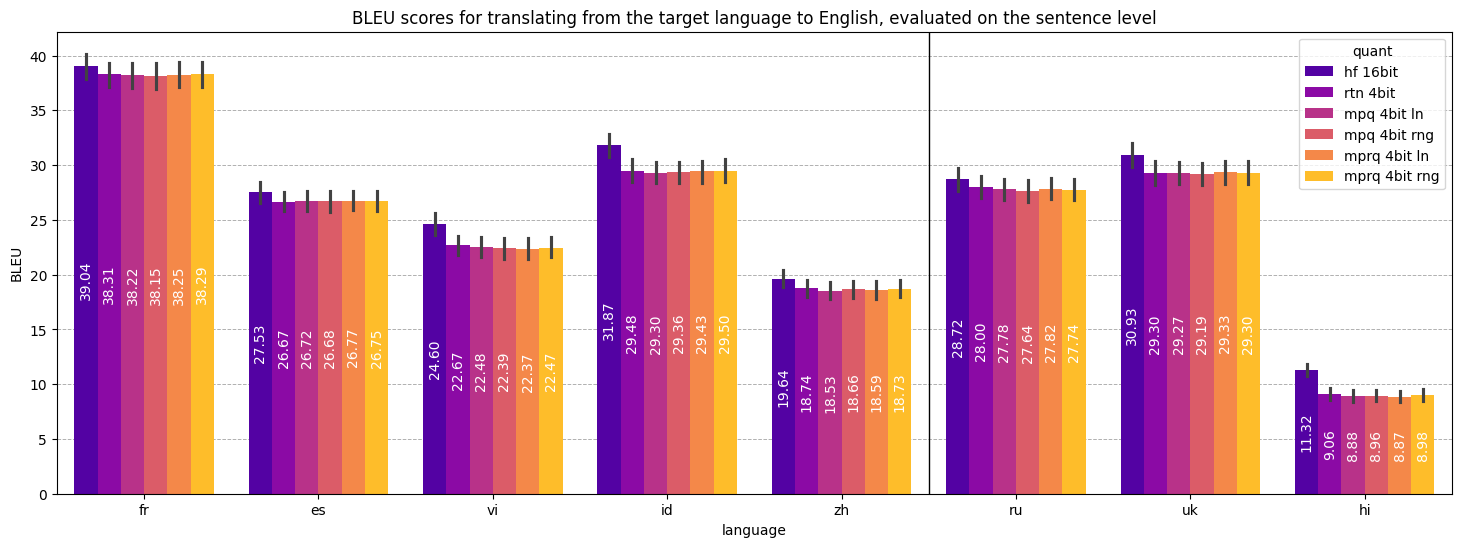

In [16]:
plt.figure(figsize=(18, 6), dpi=100)
plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)
ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="plasma", data=bleu_summary_avg[bleu_summary_avg["direction"]=="from"], saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)
ax.set_title("BLEU scores for translating from the target language to English, evaluated on the sentence level")

In [17]:
bleu_summary_avg_delta = None
columns = ["quant", "language", "BLEU", "direction"]

for lang, l_code in langs:
    ref_reverse = reference_data["en"]["text"]
    ref = reference_data[lang]["text"]

    for path, name in quants[1:]:
        data = pd.read_csv(path.format(lang=lang), index_col=0)
        data_16 = pd.read_csv(quants[0][0].format(lang=lang), index_col=0)

        for n in range(len(ref_reverse)):
            bleu_to = bleu.corpus_score([data["to"].to_list()[n]], [[ref[n]]]).score
            bleu_from = bleu.corpus_score([data["from"].to_list()[n]], [[ref_reverse[n]]]).score

            # Normalize
            bleu_to -= bleu.corpus_score([data_16["to"].to_list()[n]], [[ref[n]]]).score 
            bleu_from -= bleu.corpus_score([data_16["from"].to_list()[n]], [[ref_reverse[n]]]).score 


            line = pd.DataFrame([
                [name, lang, bleu_to, "to"], 
                [name, lang, bleu_from, "from"]
                ], columns=columns)
        
            if bleu_summary_avg_delta is None:
                bleu_summary_avg_delta = line
            else:
                bleu_summary_avg_delta = pd.concat([bleu_summary_avg_delta, line], axis=0, ignore_index=True)

bleu_summary_avg_delta["BLEU"] = bleu_summary_avg_delta["BLEU"] * -1
bleu_summary_avg_delta

,quant,language,BLEU,direction
0,rtn 4bit,fr,6.485291,to
1,rtn 4bit,fr,15.850045,from
2,rtn 4bit,fr,-0.316419,to
3,rtn 4bit,fr,-8.890907,from
4,rtn 4bit,fr,-12.472421,to
...,...,...,...,...
80955,mprq 4bit rng,hi,9.907514,from
80956,mprq 4bit rng,hi,0.270139,to
80957,mprq 4bit rng,hi,0.309676,from
80958,mprq 4bit rng,hi,-0.063498,to


Text(0.5, 1.0, 'BLEU scores for translating to the target language from English, evaluated on the sentence level, expressed as the delta between base model performance against quants')

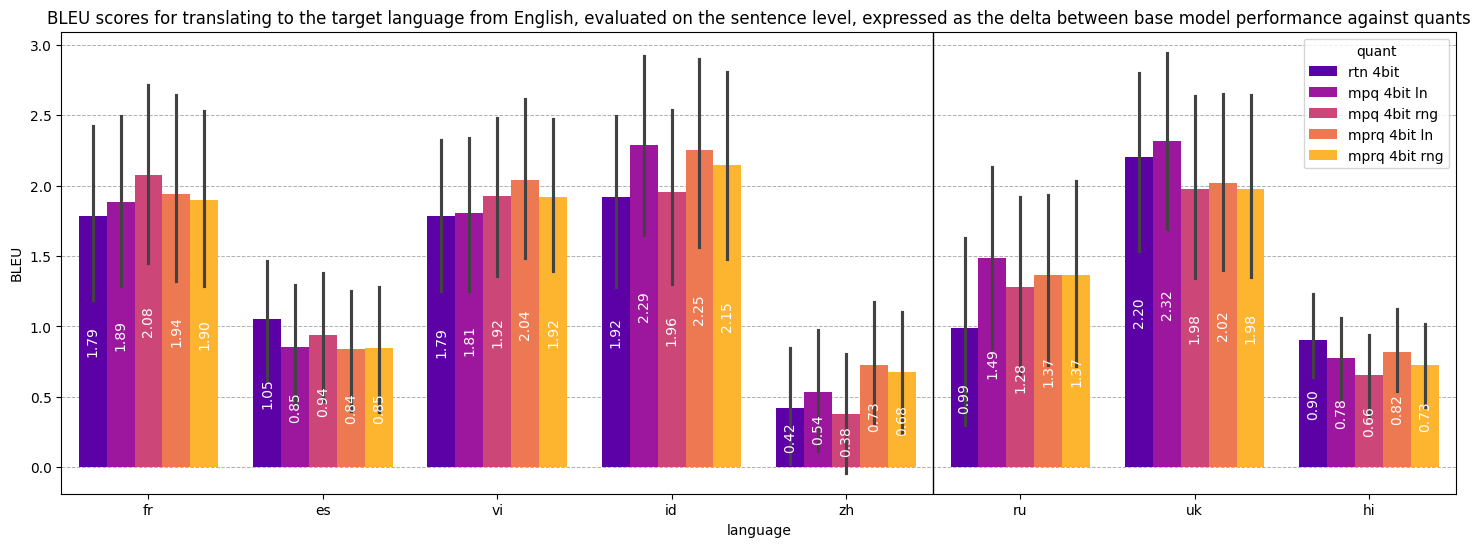

In [18]:

plt.figure(figsize=(18, 6), dpi=100)
plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)
ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="plasma", data=bleu_summary_avg_delta[bleu_summary_avg_delta["direction"]=="to"], saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)
ax.set_title("BLEU scores for translating to the target language from English, evaluated on the sentence level, expressed as the delta between base model performance against quants")

Text(0.5, 1.0, 'BLEU scores for translating from the target language tp English, evaluated on the sentence level, expressed as the delta between base model performance against quants')

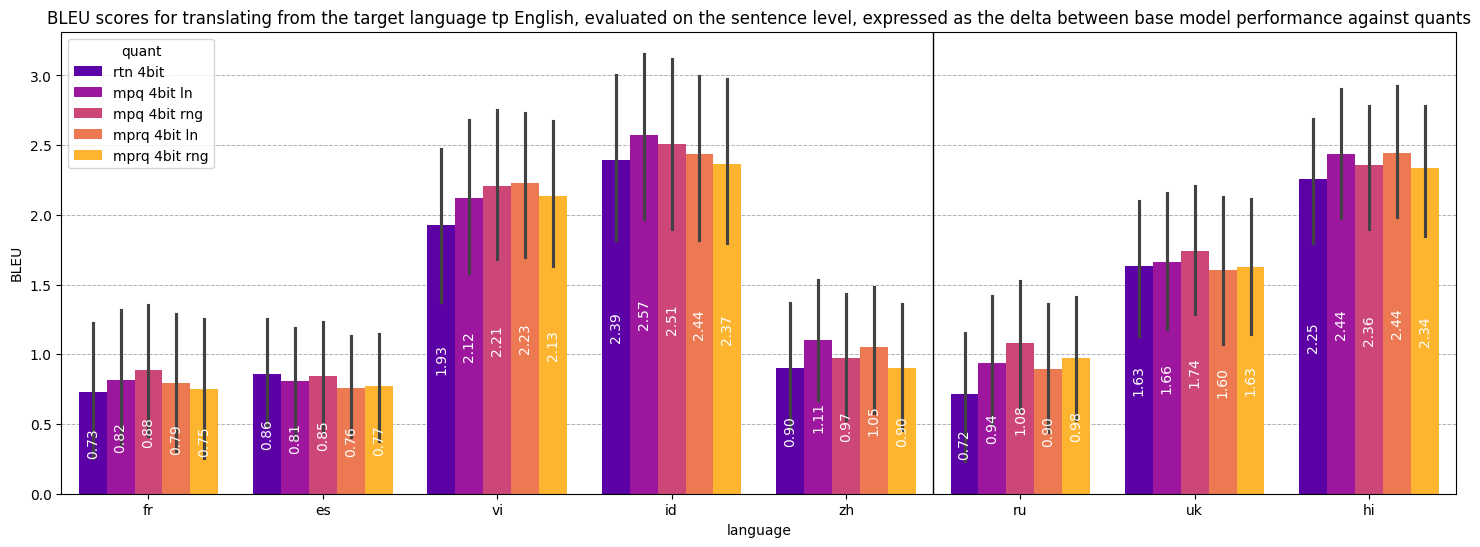

In [19]:

plt.figure(figsize=(18, 6), dpi=100)
plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)
ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="plasma", data=bleu_summary_avg_delta[bleu_summary_avg_delta["direction"]=="from"], saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)
ax.set_title("BLEU scores for translating from the target language tp English, evaluated on the sentence level, expressed as the delta between base model performance against quants")